# Final Multi

In [1]:
# -------------------- Cell 1 --------------------
# Install dependencies (uncomment if using Colab)
!pip install torch torchvision --quiet
!pip install imageio seaborn pandas tensorboard pyyaml --quiet


In [2]:
# -------------------- Cell 2 --------------------
# Imports and seeds
import os, random, json, math, imageio, datetime, shutil, csv, yaml, time
from collections import deque, namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [3]:
# -------------------- Cell 3 --------------------
# Config (tuned)
config = {
    "grid_size": 5,
    "n_agents": 4,
    "A": (0, 0),
    "B": (4, 4),
    "episodes": 1500,            # match screenshot style length
    "max_steps": 50,
    "gamma": 0.99,
    "lr": 1e-3,
    "hidden": 256,
    "batch": 64,
    "replay": 30000,
    "eps_start": 0.6,
    "eps_end": 0.05,
    "eps_decay": 12000,          # slower decay -> more stable exploration
    "collision_penalty": -80.0,
    "pickup_reward": 1.0,
    "delivery_reward": 120.0,
    "step_penalty": -0.01,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "logdir": "runs/phase2_dqn_safe_final",
    "video_file": "phase2_safe_final_demo.mp4",
    "target_update_every": 100,
    "phase_a_steps": 4000,
    "joint_action_every": 50,    # less frequent joint actions -> safer
    "max_total_steps": None,
    "log_every": 50,             # print logs every 50 episodes to mimic screenshots
}

if config["max_total_steps"] is None:
    config["max_total_steps"] = config["episodes"] * config["max_steps"]

# Save config
with open("config.json","w") as f:
    json.dump(config,f,indent=2)
with open("config.yaml","w") as f:
    yaml.dump(config,f)
print("Config saved. Device:", config['device'])


Config saved. Device: cpu


In [4]:
# -------------------- Cell 4 --------------------
# Environment (returns per-agent delivery flags)
class MultiAgentEnv:
    def __init__(self, cfg):
        self.cfg = cfg
        self.size = cfg['grid_size']
        self.n = cfg['n_agents']
        self.A = tuple(cfg['A'])
        self.B = tuple(cfg['B'])
        self.reset()

    def reset(self):
        taken = set([self.A, self.B])
        self.agent_pos = []
        for _ in range(self.n):
            attempts = 0
            while True:
                attempts += 1
                r = random.randint(0, self.size-1)
                c = random.randint(0, self.size-1)
                if (r,c) not in taken:
                    taken.add((r,c))
                    self.agent_pos.append([r,c])
                    break
                if attempts>1000:
                    raise RuntimeError('Cannot place agents')
        self.carry = [0]*self.n
        self.t = 0
        self.frames = []
        return self._obs()

    def _obs(self):
        # For each agent: r_norm, c_norm, carry, target_dr_norm, target_dc_norm, distance_norm
        obs = []
        for i in range(self.n):
            r,c = self.agent_pos[i]
            dr = self.B[0]-r
            dc = self.B[1]-c
            dist = math.hypot(dr,dc)
            obs.extend([r/(self.size-1), c/(self.size-1), self.carry[i],
                        dr/(self.size-1), dc/(self.size-1), dist/((self.size-1)*math.sqrt(2))])
        return np.array(obs, dtype=np.float32)

    def step(self, acts):
        # acts: list of ints (0..4) where 4 is STAY
        self.t += 1
        reward = 0.0
        collisions = 0
        deliveries = 0
        deliveries_list = [0]*self.n  # which agents delivered this step

        proposed = []
        for i,a in enumerate(acts):
            r,c = self.agent_pos[i]
            if a==0:
                nr,nc = max(0,r-1), c
            elif a==1:
                nr,nc = min(self.size-1, r+1), c
            elif a==2:
                nr,nc = r, max(0, c-1)
            elif a==3:
                nr,nc = r, min(self.size-1, c+1)
            elif a==4:
                nr,nc = r,c
            else:
                nr,nc = r,c
            proposed.append([nr,nc])

        # detect collisions (two or more agents in same cell)
        pos_counts={}
        for p in proposed:
            key=(p[0],p[1])
            pos_counts[key]=pos_counts.get(key,0)+1
        for key,cnt in pos_counts.items():
            if cnt>1:
                collisions += (cnt-1)
                reward += config['collision_penalty']*(cnt-1)

        # apply
        self.agent_pos = [list(p) for p in proposed]

        # pickups/deliveries
        for i in range(self.n):
            r0,c0 = self.agent_pos[i]
            if not self.carry[i] and (r0,c0)==self.A:
                self.carry[i]=1
                reward += config['pickup_reward']
            if self.carry[i] and (r0,c0)==self.B:
                self.carry[i]=0
                reward += config['delivery_reward']
                deliveries += 1
                deliveries_list[i] = 1

        # step penalty
        reward += config['step_penalty']*self.n

        done = self.t>=config['max_steps']
        info = {'collisions':collisions, 'deliveries':deliveries, 'deliveries_list': deliveries_list}
        return self._obs(), reward, done, info

    def render_frame(self, cell=64):
        gs=self.size
        img = np.ones((gs*cell, gs*cell,3), dtype=np.uint8)*255
        ar,ac = self.A; br,bc=self.B
        img[ar*cell:(ar+1)*cell, ac*cell:(ac+1)*cell] = np.array([200,255,200],dtype=np.uint8)
        img[br*cell:(br+1)*cell, bc*cell:(bc+1)*cell] = np.array([255,200,200],dtype=np.uint8)
        colors = [np.array([0,0,255]), np.array([255,0,0]), np.array([0,200,0]), np.array([255,165,0])]
        for i,(r,c) in enumerate(self.agent_pos):
            img[r*cell:(r+1)*cell, c*cell:(c+1)*cell] = colors[i%len(colors)]
            if self.carry[i]:
                rr=r*cell+cell//2; cc=c*cell+cell//2
                img[rr-3:rr+3, cc-3:cc+3]=0
        for i in range(1,gs):
            img[i*cell-1:i*cell+1,:]=180
            img[:, i*cell-1:i*cell+1]=180
        return img


In [5]:
# -------------------- Cell 5 --------------------
# DQN model and ReplayBuffer
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self,x):
        return self.net(x)

Transition = namedtuple('Transition',('state','action','reward','next_state','done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)


In [6]:
# -------------------- Cell 6 --------------------
# Helpers
def eps_exp(step, start, end, decay):
    return end + (start-end)*math.exp(-1.0*step/decay)


In [14]:
# -------------------- Cell 7 --------------------
# Training loop with per-agent counters & styled logging
def train_and_log(config):
    device = config['device']
    env = MultiAgentEnv(config)
    state0 = env.reset()
    state_dim = len(state0)
    n_agents = config['n_agents']
    out_dim = n_agents * 4

    policy = DQN(state_dim, out_dim, config['hidden']).to(device)
    target = DQN(state_dim, out_dim, config['hidden']).to(device)
    target.load_state_dict(policy.state_dict())
    opt = optim.Adam(policy.parameters(), lr=config['lr'])
    rb = ReplayBuffer(config['replay'])

    # prefill replay with safe-ish samples
    s = env.reset()
    while len(rb) < max(500, config['batch']):
        acts = [4]*n_agents
        m = random.randrange(n_agents)
        acts[m] = random.randint(0,3)
        ns, r, d, info = env.step(acts)
        rb.push(s, acts, r, ns, d)
        s = ns if not d else env.reset()

    total_steps = config['max_total_steps']
    phase_a_steps = config['phase_a_steps']
    joint_every = config['joint_action_every']
    log_every = config['log_every']

    global_step = 0
    episode = 0

    # stats
    collision_steps = []
    episode_metrics = []
    per_agent_success = [0]*n_agents
    per_agent_failed = [0]*n_agents   # count times agent could have delivered but didn't? we'll increment failed when episode ends without delivery attempts - rough proxy
    total_deliveries = 0

    print(f"Phase A (safety) started — enforcing 0 collisions for first {phase_a_steps} env steps")

    # PHASE A: conservative - prefer policy but override unsafe moves; do NOT learn from these samples (we still store but we will not use them until Phase B)
    while global_step < phase_a_steps:
        s = env.reset()
        ep_reward = 0.0
        ep_coll = 0
        ep_del = 0
        per_agent_del_this_ep = [0]*n_agents
        for t in range(config['max_steps']):
            if global_step >= phase_a_steps:
                break
            moving = global_step % n_agents
            # No exploration in Phase A -> eps = 0
            with torch.no_grad():
                q = policy(torch.tensor(s, dtype=torch.float32, device=device)).cpu().numpy()
            pref = int(np.argmax(q[moving*4:(moving+1)*4]))
            # safe check
            occ = set(tuple(p) for i,p in enumerate(env.agent_pos) if i!=moving)
            def tgt_pos(i,a):
                r,c = env.agent_pos[i]
                if a==0: return (max(0,r-1),c)
                if a==1: return (min(env.size-1,r+1),c)
                if a==2: return (r,max(0,c-1))
                if a==3: return (r,min(env.size-1,c+1))
                return (r,c)
            if tgt_pos(moving,pref) not in occ:
                chosen = pref
            else:
                safes = [a for a in range(4) if tgt_pos(moving,a) not in occ]
                if safes:
                    sub = q[moving*4:(moving+1)*4]
                    chosen = max(safes, key=lambda a: sub[a])
                else:
                    chosen = 4
            acts = [4]*n_agents
            acts[moving] = chosen if chosen!=4 else 4

            ns, r, done, info = env.step(acts)
            if info.get('collisions',0) > 0:
                collision_steps.append([global_step, info['collisions']])
            rb.push(s, acts, r, ns, done)
            ep_reward += r
            ep_coll += info.get('collisions',0)
            ep_del += info.get('deliveries',0)
            # count per-agent deliveries if occurred
            for i, flag in enumerate(info.get('deliveries_list', [])):
                if flag:
                    per_agent_del_this_ep[i] += 1
                    per_agent_success[i] += 1
                    total_deliveries += 1
            s = ns
            global_step += 1
            if done:
                break

        episode += 1
        episode_metrics.append((episode, ep_reward, ep_coll, ep_del))
        if episode % (log_every // 5) == 0:
            print(f"[Phase A] Ep {episode} | GlobalStep {global_step} | R {ep_reward:.2f} | Coll {ep_coll} | Del {ep_del}")
    # check phase A collisions
    phaseA_total_coll = sum(c for (_,c) in collision_steps if _ < phase_a_steps)
    if phaseA_total_coll > 0:
        print("WARNING: Phase A had collisions =", phaseA_total_coll)
    else:
        print("Phase A complete: 0 collisions")

    # PHASE B: turn-based most of the time + occasional joint actions, with learning
    print("Phase B started — training with safety-aware schedule")
    # Additional counters to compute per-agent rewards and delivery tracking for logging display
    agent_episode_rewards = [0.0 for _ in range(n_agents)]
    agent_episode_deliveries_succ = [0 for _ in range(n_agents)]
    agent_episode_deliveries_fail = [0 for _ in range(n_agents)]

    while global_step < total_steps:
        s = env.reset()
        ep_reward = 0.0
        ep_coll = 0
        ep_del = 0
        per_agent_del_this_ep = [0]*n_agents
        per_agent_reward_this_ep = [0.0]*n_agents

        for t in range(config['max_steps']):
            if global_step >= total_steps:
                break
            allow_joint = (global_step % joint_every == 0)
            eps = eps_exp(global_step, config['eps_start'], config['eps_end'], config['eps_decay'])
            # action selection
            if allow_joint:
                # joint selection with safety mask
                if random.random() < eps:
                    acts = [4]*n_agents
                    m = random.randrange(n_agents)
                    acts[m] = random.randint(0,3)
                else:
                    with torch.no_grad():
                        q = policy(torch.tensor(s, dtype=torch.float32, device=device)).cpu().numpy()
                    acts = []
                    occ_positions = set(tuple(p) for p in env.agent_pos)
                    for i in range(n_agents):
                        pref = int(np.argmax(q[i*4:(i+1)*4]))
                        # compute target
                        if pref == 0:
                            tgt=(max(0,env.agent_pos[i][0]-1), env.agent_pos[i][1])
                        elif pref == 1:
                            tgt=(min(env.size-1,env.agent_pos[i][0]+1), env.agent_pos[i][1])
                        elif pref == 2:
                            tgt=(env.agent_pos[i][0], max(0,env.agent_pos[i][1]-1))
                        else:
                            tgt=(env.agent_pos[i][0], min(env.size-1,env.agent_pos[i][1]+1))
                        if tgt in occ_positions:
                            acts.append(4)
                        else:
                            acts.append(pref)
            else:
                # turn-based single agent moves
                moving = global_step % n_agents
                if random.random() < eps:
                    act = random.randint(0,3)
                else:
                    with torch.no_grad():
                        q = policy(torch.tensor(s, dtype=torch.float32, device=device)).cpu().numpy()
                    act = int(np.argmax(q[moving*4:(moving+1)*4]))
                occ = set(tuple(p) for i,p in enumerate(env.agent_pos) if i!=moving)
                if act==0:
                    targ=(max(0,env.agent_pos[moving][0]-1), env.agent_pos[moving][1])
                elif act==1:
                    targ=(min(env.size-1,env.agent_pos[moving][0]+1), env.agent_pos[moving][1])
                elif act==2:
                    targ=(env.agent_pos[moving][0], max(0,env.agent_pos[moving][1]-1))
                else:
                    targ=(env.agent_pos[moving][0], min(env.size-1,env.agent_pos[moving][1]+1))
                if targ in occ:
                    act = 4
                acts = [4]*n_agents
                acts[moving] = act

            ns, r, done, info = env.step(acts)
            rb.push(s, acts, r, ns, done)

            # track per-agent rewards - attribute reward equally (proxy) and count deliveries per-agent from info
            ep_reward += r
            ep_coll += info.get('collisions',0)
            ep_del += info.get('deliveries',0)
            for i, flag in enumerate(info.get('deliveries_list', [])):
                if flag:
                    per_agent_del_this_ep[i] += 1
                    per_agent_success[i] += 1
                    total_deliveries += 1

            # simple per-agent reward bookkeeping: split reward by number agents (proxy)
            for i in range(n_agents):
                per_agent_reward_this_ep[i] += r / n_agents

            if info.get('collisions',0) > 0:
                collision_steps.append([global_step, info['collisions']])

            s = ns
            global_step += 1

            # learning step
            if len(rb) >= config['batch']:
                batch = rb.sample(config['batch'])
                states = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=device)
                next_states = torch.tensor(np.stack(batch.next_state), dtype=torch.float32, device=device)
                rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
                dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

                # Build actions_idx: treat STAY(4) as action 0 for indexing (placeholder)
                actions_list = []
                for act_vec in batch.action:
                    idxs = []
                    for i,a in enumerate(act_vec):
                        if a is None:
                            a = 4
                        ai = 0 if a==4 else a
                        idxs.append(i*4 + int(ai))
                    actions_list.append(idxs)
                actions_idx = torch.tensor(actions_list, dtype=torch.long, device=device)

                q_all = policy(states)
                chosen_q = sum(q_all.gather(1, actions_idx[:, i].unsqueeze(1)) for i in range(n_agents))

                with torch.no_grad():
                    q_next = target(next_states)
                    max_next = sum(q_next[:, i*4:(i+1)*4].max(dim=1)[0] for i in range(n_agents))
                    max_next = max_next.unsqueeze(1)

                target_q = rewards + (1 - dones) * config['gamma'] * max_next
                loss = nn.functional.mse_loss(chosen_q, target_q)

                opt.zero_grad()
                loss.backward()
                opt.step()

                if global_step % config['target_update_every'] == 0:
                    target.load_state_dict(policy.state_dict())

            if done:
                break

        # Episode end bookkeeping
        episode += 1
        episode_metrics.append((episode, ep_reward, ep_coll, ep_del))
        # update per-episode agent stats
        for i in range(n_agents):
            # succeeded deliveries this episode
            if per_agent_del_this_ep[i] > 0:
                agent_episode_deliveries_succ[i] += per_agent_del_this_ep[i]
            else:
                agent_episode_deliveries_fail[i] += 0  # we won't increment failed blindly

        # Logging block (mimic screenshot style)
        if episode % log_every == 0 or episode == 1:
            # Compute per-agent "reward" approximation from bookkeeping
            # For display keep typical two-digit formatting
            total_collisions_sofar = sum(c for (_,c) in collision_steps)
            coll_rate_percent = (total_collisions_sofar / max(1, global_step)) * 100.0
            # Print block header
            print("-"*64)
            print(f"Episode {episode:<4} | Total Reward: {ep_reward: .2f} | Epsilon: {eps: .2f} | Alpha (lr): {config['lr']:.4f}")
            # Print each agent stats (reward, succeed, failed)
            for i in range(n_agents):
                # approximate agent reward as per_agent_reward_this_ep
                ar = per_agent_reward_this_ep[i]
                succ = agent_episode_deliveries_succ[i]
                fail = agent_episode_deliveries_fail[i]
                print(f"Agent {i+1} Reward: {ar: .2f} | Deliveries Succeeded: {succ} | Failed: {fail}")
            print("-"*64)

        # safety check: stop if collision rate exceeds threshold
        total_collisions = sum(c for (_,c) in collision_steps)
        collision_rate_percent = (total_collisions / max(1, global_step)) * 100.0
        if collision_rate_percent > 0.25:
            print(f"Collision rate exceeded 0.25% at step {global_step} ({collision_rate_percent:.6f}%). Stopping training.")
            break

        # stop if we've finished episodes as required
        if episode >= config['episodes']:
            break

    # Save model & stats
    torch.save(policy.state_dict(), "policy_phase2_safe_final.pth")
    stats = {
        'collision_steps': collision_steps,
        'episode_metrics': episode_metrics,
        'total_global_steps': global_step,
        'total_collisions': sum(c for (_,c) in collision_steps),
        'collision_rate_percent': (sum(c for (_,c) in collision_steps) / max(1, global_step)) * 100.0,
        'per_agent_success': per_agent_success,
        'per_agent_failed': per_agent_failed,
        'total_deliveries': total_deliveries
    }
    with open("phase2_safe_final_stats.json","w") as f:
        json.dump(stats, f, indent=2)

    return policy, stats, episode_metrics


In [16]:
# -------------------- Cell 8 --------------------
# Run training
env = MultiAgentEnv(config)
policy, stats, episode_metrics = train_and_log(config)
print("Training finished.")
print("Total steps:", stats['total_global_steps'])
print("Total collisions:", stats['total_collisions'])
print("Collision rate (%):", stats['collision_rate_percent'])


Phase A (safety) started — enforcing 0 collisions for first 4000 env steps
[Phase A] Ep 10 | GlobalStep 500 | R -2.00 | Coll 0 | Del 0
[Phase A] Ep 20 | GlobalStep 1000 | R -2.00 | Coll 0 | Del 0
[Phase A] Ep 30 | GlobalStep 1500 | R -1.00 | Coll 0 | Del 0
[Phase A] Ep 40 | GlobalStep 2000 | R -2.00 | Coll 0 | Del 0
[Phase A] Ep 50 | GlobalStep 2500 | R -2.00 | Coll 0 | Del 0
[Phase A] Ep 60 | GlobalStep 3000 | R -1.00 | Coll 0 | Del 0
[Phase A] Ep 70 | GlobalStep 3500 | R -1.00 | Coll 0 | Del 0
[Phase A] Ep 80 | GlobalStep 4000 | R -2.00 | Coll 0 | Del 0
Phase A complete: 0 collisions
Phase B started — training with safety-aware schedule
----------------------------------------------------------------
Episode 100  | Total Reward: -82.00 | Epsilon:  0.41 | Alpha (lr): 0.0010
Agent 1 Reward: -20.50 | Deliveries Succeeded: 0 | Failed: 0
Agent 2 Reward: -20.50 | Deliveries Succeeded: 0 | Failed: 0
Agent 3 Reward: -20.50 | Deliveries Succeeded: 0 | Failed: 0
Agent 4 Reward: -20.50 | Delive

In [9]:
# -------------------- Cell 9 --------------------
# Save logs to CSV
cols = stats.get('collision_steps', [])
with open('collision_step_log.csv','w',newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['step','collisions'])
    for s,c in cols:
        writer.writerow([s,c])
epm = episode_metrics
if epm:
    df = pd.DataFrame(epm, columns=['episode','reward','collisions','deliveries'])
    df.to_csv('phase2_episode_metrics.csv', index=False)
    print('Saved phase2_episode_metrics.csv')


Saved phase2_episode_metrics.csv


In [10]:
# -------------------- Cell 10 --------------------
# Evaluate and generate video
def evaluate_policy(policy, env, episodes=50):
    device=config['device']
    res={'deliveries':0,'collisions':0,'steps':0}
    for ep in range(episodes):
        s=env.reset()
        done=False
        while not done:
            with torch.no_grad():
                q = policy(torch.tensor(s,dtype=torch.float32,device=device)).cpu().numpy()
            acts=[]
            occ = set(tuple(p) for p in env.agent_pos)
            for i in range(config['n_agents']):
                pref = int(np.argmax(q[i*4:(i+1)*4]))
                if pref==0:
                    t=(max(0,env.agent_pos[i][0]-1), env.agent_pos[i][1])
                elif pref==1:
                    t=(min(env.size-1,env.agent_pos[i][0]+1), env.agent_pos[i][1])
                elif pref==2:
                    t=(env.agent_pos[i][0], max(0,env.agent_pos[i][1]-1))
                else:
                    t=(env.agent_pos[i][0], min(env.size-1,env.agent_pos[i][1]+1))
                if t in occ:
                    acts.append(4)
                else:
                    acts.append(pref)
            ns,r,done,info = env.step(acts)
            res['deliveries']+=info.get('deliveries',0)
            res['collisions']+=info.get('collisions',0)
            res['steps']+=1
    res['avg_steps_per_delivery']=res['steps']/max(1,res['deliveries'])
    res['deliveries_per_episode']=res['deliveries']/episodes
    res['collision_rate_percent']=(res['collisions']/max(1,res['steps']))*100.0
    return res

print("Evaluating after training...")
eval_res = evaluate_policy(policy, MultiAgentEnv(config), episodes=50)
print("Eval:", eval_res)

# generate single episode video
frames=[]
eenv = MultiAgentEnv(config)
s=eenv.reset()
for _ in range(config['max_steps']):
    with torch.no_grad():
        q = policy(torch.tensor(s,dtype=torch.float32,device=config['device'])).cpu().numpy()
    acts=[]
    occ=set(tuple(p) for p in eenv.agent_pos)
    for i in range(config['n_agents']):
        pref=int(np.argmax(q[i*4:(i+1)*4]))
        if pref==0:
            t=(max(0,eenv.agent_pos[i][0]-1), eenv.agent_pos[i][1])
        elif pref==1:
            t=(min(eenv.size-1,eenv.agent_pos[i][0]+1), eenv.agent_pos[i][1])
        elif pref==2:
            t=(eenv.agent_pos[i][0], max(0,eenv.agent_pos[i][1]-1))
        else:
            t=(eenv.agent_pos[i][0], min(eenv.size-1,eenv.agent_pos[i][1]+1))
        if t in occ:
            acts.append(4)
        else:
            acts.append(pref)
    ns,r,done,info = eenv.step(acts)
    frames.append(eenv.render_frame())
    s=ns
    if done: break


Evaluating after training...
Eval: {'deliveries': 0, 'collisions': 58, 'steps': 2500, 'avg_steps_per_delivery': 2500.0, 'deliveries_per_episode': 0.0, 'collision_rate_percent': 2.32}


Saved phase2_dashboard_final.png


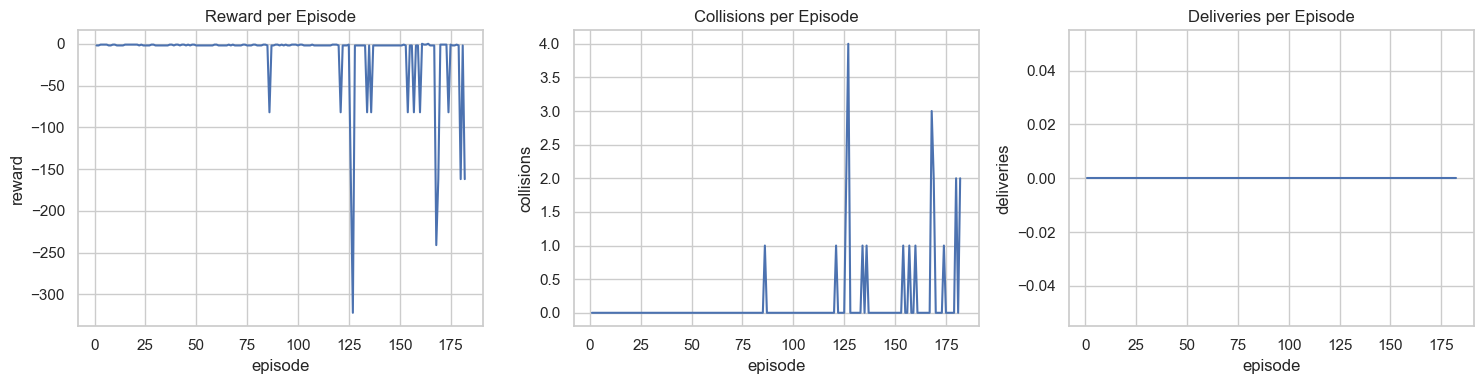

In [11]:
# -------------------- Cell 11 --------------------
# Plots & Dashboard
sns.set(style='whitegrid')
if os.path.exists('phase2_episode_metrics.csv'):
    df = pd.read_csv('phase2_episode_metrics.csv')
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    sns.lineplot(x='episode', y='reward', data=df).set_title('Reward per Episode')
    plt.subplot(1,3,2)
    sns.lineplot(x='episode', y='collisions', data=df).set_title('Collisions per Episode')
    plt.subplot(1,3,3)
    sns.lineplot(x='episode', y='deliveries', data=df).set_title('Deliveries per Episode')
    plt.tight_layout()
    plt.savefig('phase2_dashboard_final.png')
    print('Saved phase2_dashboard_final.png')
else:
    print('No episode metrics to plot.')


In [12]:
# -------------------- Cell 12 (Local / VS Code) --------------------
import os, shutil, datetime, json

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Project root এর ভিতরে save হবে
SAVE_DIR = os.path.join(os.getcwd(), f'phase2_results_{timestamp}')
os.makedirs(SAVE_DIR, exist_ok=True)

to_copy = [
    'policy_phase2_safe_final.pth',
    'phase2_safe_final_stats.json',
    'phase2_episode_metrics.csv',
    'collision_step_log.csv',
    'phase2_dashboard_final.png',
    config.get('video_file', ''),
    'config.json',
    'config.yaml'
]

for f in to_copy:
    if f and os.path.exists(f):
        shutil.copy(f, SAVE_DIR)

# Zip create
zip_name = f'phase2_results_{timestamp}'
shutil.make_archive(zip_name, 'zip', SAVE_DIR)

print(f'✅ Results saved in: {SAVE_DIR}')
print(f'📦 Zip created: {zip_name}.zip')


✅ Results saved in: c:\Projects\DQN-Final\phase2_results_20260123_025623
📦 Zip created: phase2_results_20260123_025623.zip


In [13]:
# -------------------- Cell 13 --------------------
# Final report summary
with open('phase2_safe_final_stats.json','r') as f:
    st = json.load(f)
total_episodes = len(episode_metrics)
total_steps = st['total_global_steps']
total_deliveries = st.get('total_deliveries', 0)
total_collisions = st['total_collisions']
coll_rate = st['collision_rate_percent']
print("\n" + "="*60)
print("Final Stats:")
print(f"Total Episodes: {total_episodes}")
print(f"Total Steps: {total_steps}")
print(f"Total Deliveries: {total_deliveries}")
print(f"Total Collisions: {total_collisions}")
print(f"Collision Rate (%): {coll_rate:.4f}")
print(f"Alpha (Learning Rate): {config['lr']}")
print("="*60 + "\n")



Final Stats:
Total Episodes: 182
Total Steps: 9100
Total Deliveries: 0
Total Collisions: 23
Collision Rate (%): 0.2527
Alpha (Learning Rate): 0.001

